# Autoencoders

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.utils import plot_model

Using TensorFlow backend.


# Utility Functions

In [2]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

# MNIST

## Deep Autoencoder

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


In [4]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#autoencoder.fit(x_train, x_train, epochs=3)

In [5]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               101136    
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


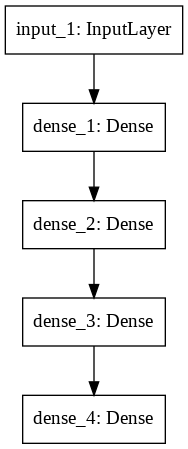

In [6]:
plot_model(autoencoder)

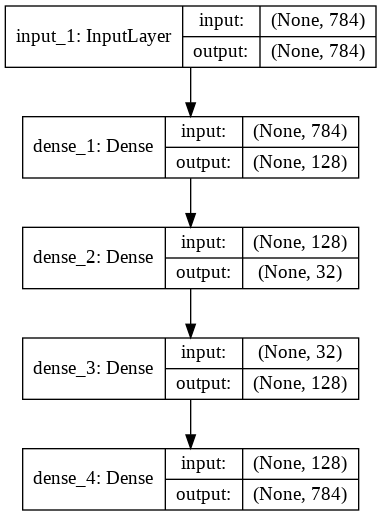

In [7]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96)

In [8]:
%%time
autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 6s 106us/step - loss: 0.1352
Epoch 2/3
60000/60000 [==============================] - 5s 78us/step - loss: 0.0969
Epoch 3/3
60000/60000 [==============================] - 5s 78us/step - loss: 0.0920
CPU times: user 18.2 s, sys: 1.42 s, total: 19.6 s
Wall time: 16.1 s


( _Colab CPU: around 30s. Colab GPU: around 16s. Times might differ._ )

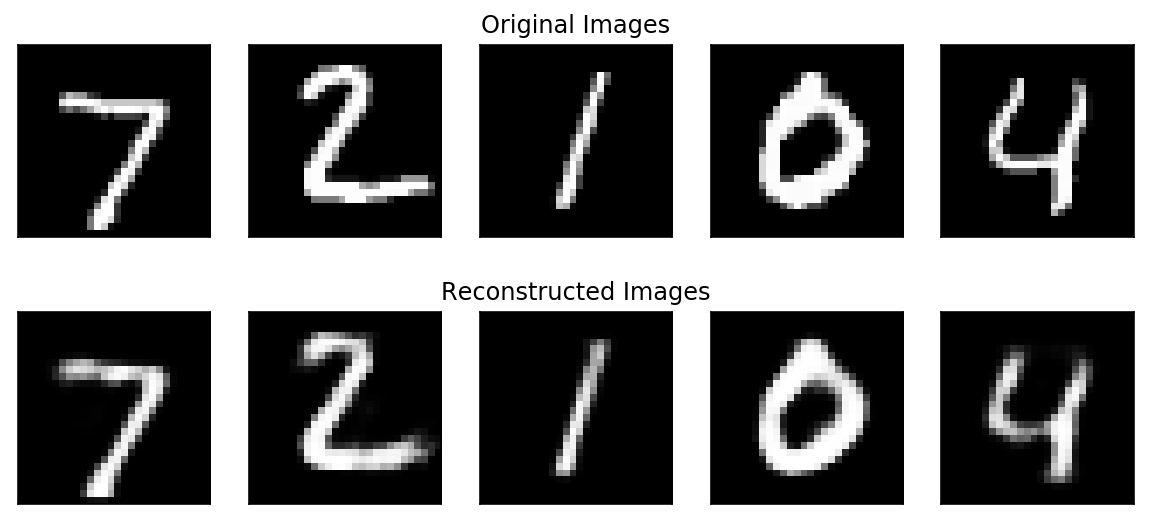

In [9]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))   # inside it does autoencoder.predict(x_test)

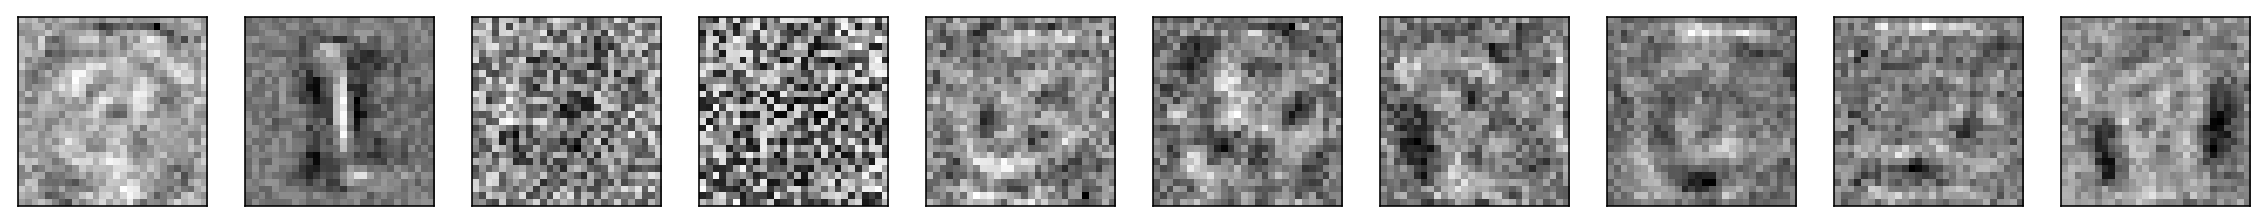

In [10]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

## Shallow Autoencoder

In [11]:
%%time
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 4s 65us/step - loss: 0.1615
Epoch 2/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.1036
Epoch 3/5
60000/60000 [==============================] - 4s 62us/step - loss: 0.0963
Epoch 4/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0950
Epoch 5/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0945
CPU times: user 24.8 s, sys: 2.12 s, total: 26.9 s
Wall time: 19.3 s


( _Colab CPU: around 22s. Colab GPU: around 19s. Times might differ_ )

In [12]:
%%time
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.0942
Epoch 2/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.0941
Epoch 3/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0939
Epoch 4/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.0938
Epoch 5/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.0937
CPU times: user 24.7 s, sys: 2.12 s, total: 26.8 s
Wall time: 19.2 s


( _Colab CPU: around 22s. Colab GPU: around 19s. Times might differ_ )

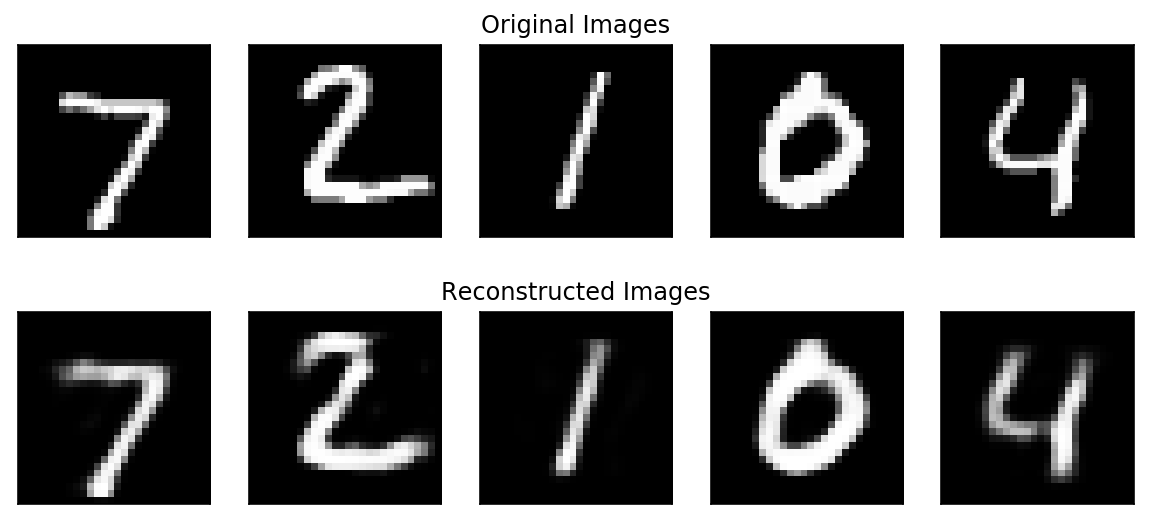

In [13]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

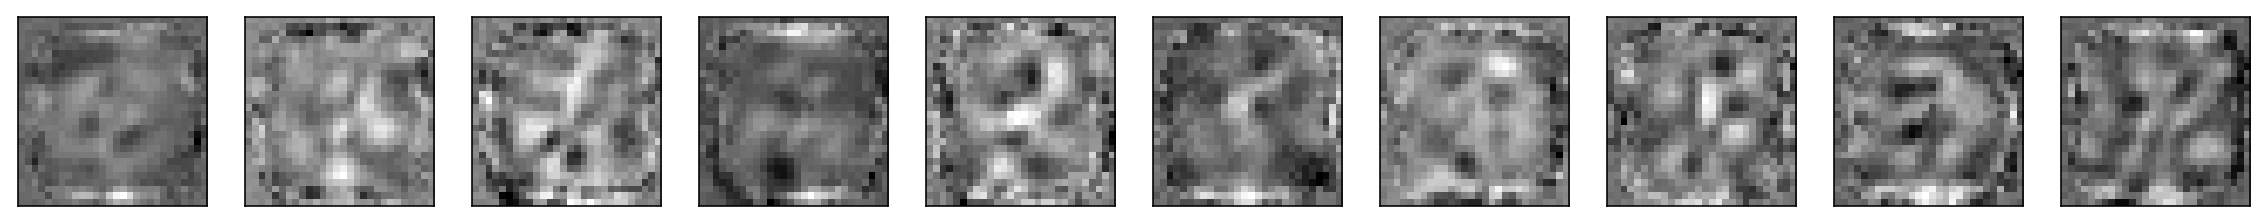

In [14]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+20].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Denoising Autoencoder

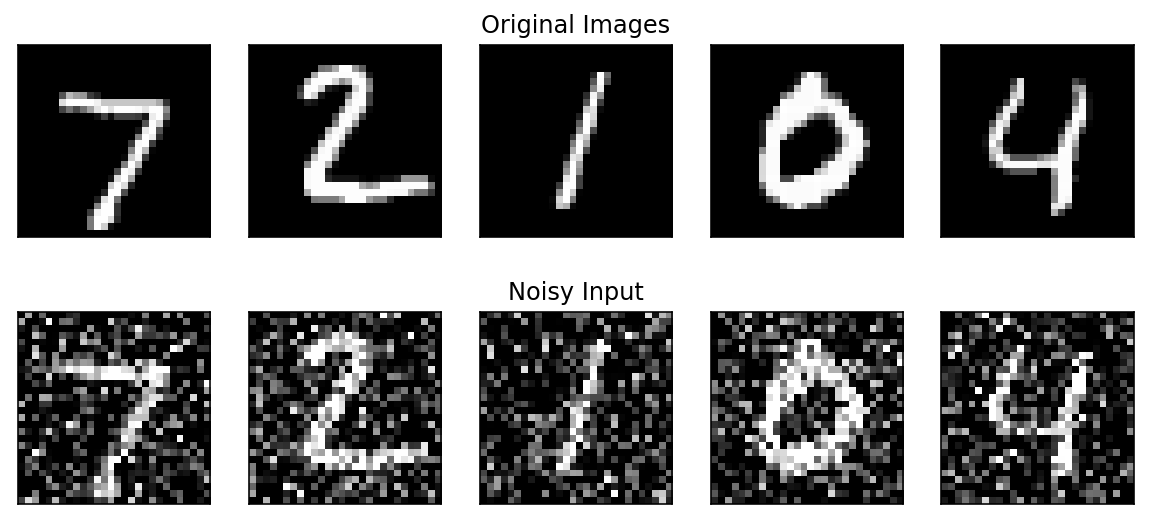

In [15]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

In [16]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#autoencoder.fit(x_train_noisy, x_train, epochs=10)

In [17]:
%%time
autoencoder.fit(x_train_noisy, x_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1634
Epoch 2/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1272
Epoch 3/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1201
Epoch 4/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1170
Epoch 5/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1150
Epoch 6/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1136
Epoch 7/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1124
Epoch 8/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1111
Epoch 9/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1102
Epoch 10/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.1095
CPU times: user 59.3 s, sys: 4.33 s, total: 1min 3s
Wall time: 48.2 s


( _Colab CPU: around 1m42s. Colab GPU: around 48s. Times might differ_ )

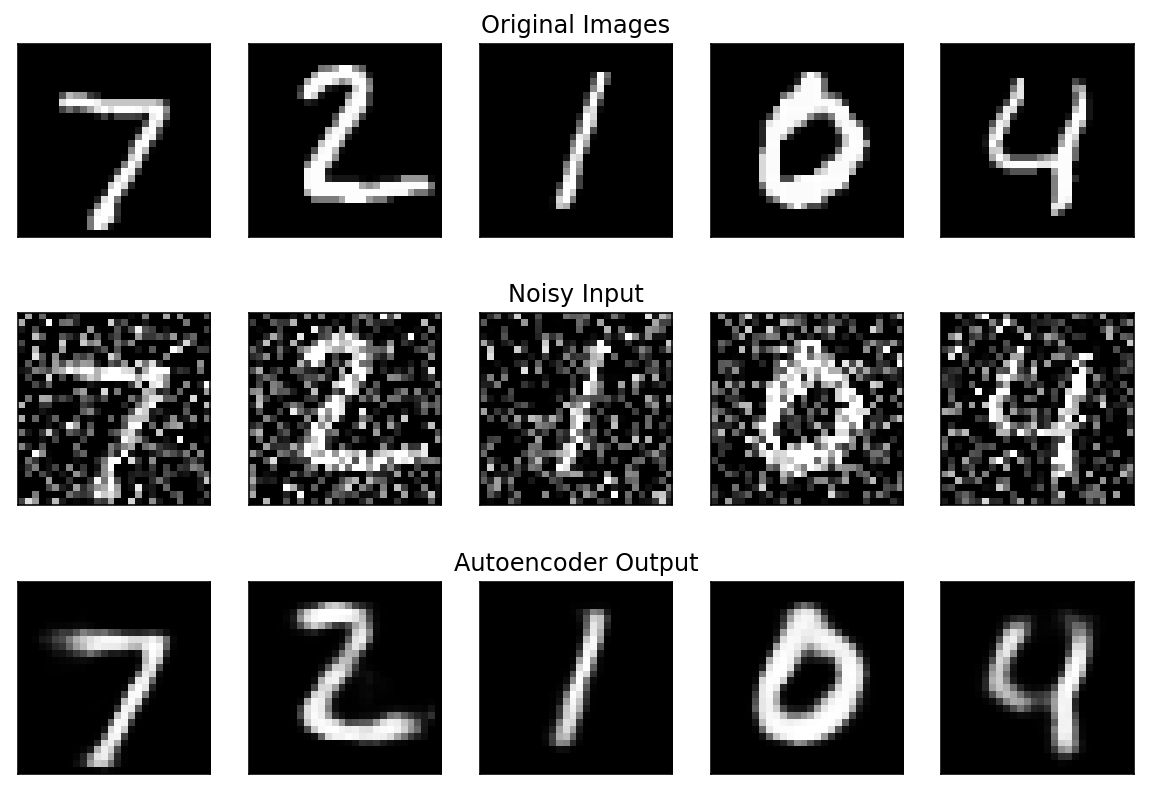

In [18]:
n = 5
plt.figure(figsize=(10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

# Sparse Autoencoders

In [19]:
%%time
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_standard = Model(input_img, output_img)
autoencoder_standard.compile(optimizer='adam', loss='binary_crossentropy')
history_standard = autoencoder_standard.fit(x_train, x_train, epochs=20)

encoded_standard = Model(input_img, code)

Epoch 1/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.1623
Epoch 2/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.1047
Epoch 3/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.0966
Epoch 4/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0952
Epoch 5/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0946
Epoch 6/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0943
Epoch 7/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0941
Epoch 8/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.0939
Epoch 9/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.0938
Epoch 10/20
60000/60000 [==============================] - 4s 67us/step - loss: 0.0937
Epoch 11/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0936
Epoch 12/20
60000/60000 [===========================

( _Colab CPU: around 1m27s. Colab GPU: around 1m18s. Times might differ_ )

In [20]:
%%time
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer='adam', loss='binary_crossentropy')
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=20)

encoded_regularized = Model(input_img, code)

Epoch 1/20
60000/60000 [==============================] - 4s 67us/step - loss: 0.1829
Epoch 2/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.1280
Epoch 3/20
60000/60000 [==============================] - 4s 66us/step - loss: 0.1182
Epoch 4/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.1143
Epoch 5/20
60000/60000 [==============================] - 4s 66us/step - loss: 0.1119
Epoch 6/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.1102
Epoch 7/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.1090
Epoch 8/20
60000/60000 [==============================] - 4s 66us/step - loss: 0.1080
Epoch 9/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.1072
Epoch 10/20
60000/60000 [==============================] - 4s 67us/step - loss: 0.1065
Epoch 11/20
60000/60000 [==============================] - 4s 67us/step - loss: 0.1060
Epoch 12/20
60000/60000 [===========================

( _Colab CPU: around 1m28s. Colab GPU: around 1m19s. Times might differ._ )

> NOTE. If you try the code on this notebook for a CPU vs GPU speed comparison, the performance improvements with GPU is visible, but not enormous. Remember we are dealing with MNIST, toy-like, small images.. 

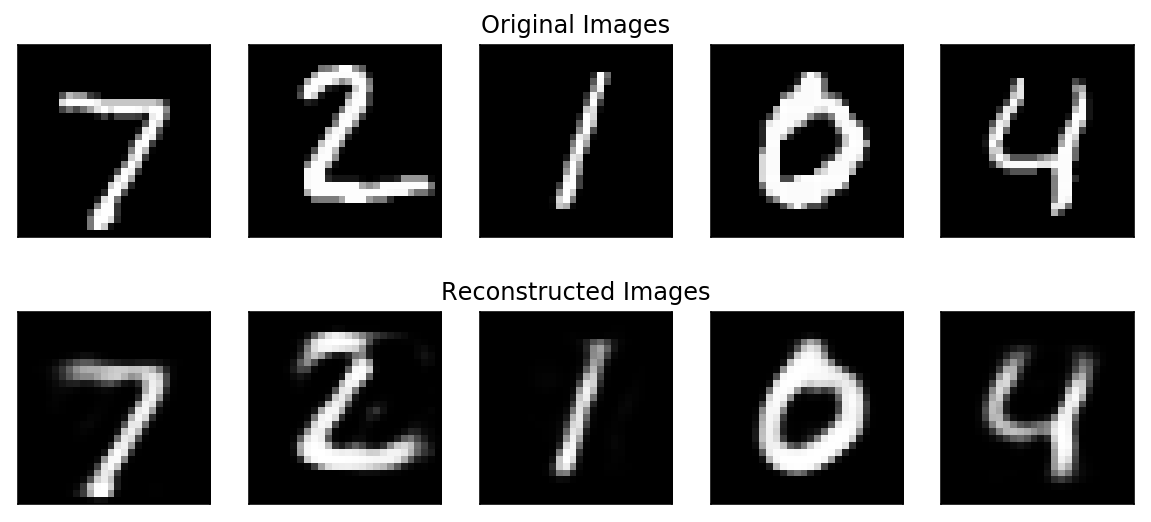

In [21]:
plot_autoencoder_outputs(autoencoder_regularized, 5, (28, 28))

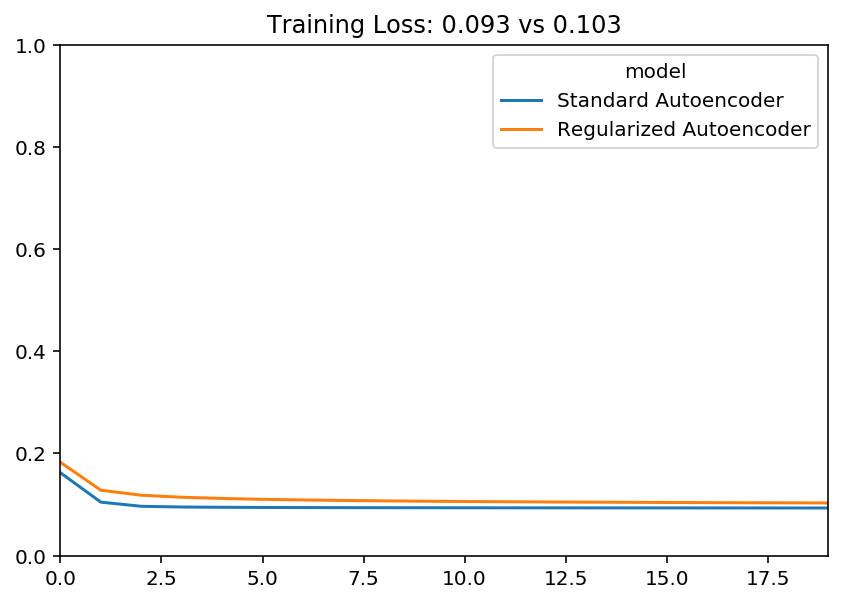

In [22]:
plot_compare_histories([history_standard, history_regularized], 
                       ['Standard Autoencoder', 'Regularized Autoencoder'], plot_accuracy=False)

In [23]:
autoencoder_standard.evaluate(x_test, x_test)

10000/10000 [==============================] - 0s 35us/step


0.09206279991865159

In [24]:
autoencoder_regularized.evaluate(x_test, x_test)

10000/10000 [==============================] - 0s 37us/step


0.10176026202440262

In [25]:
print(encoded_standard.predict(x_test).mean())
print(encoded_regularized.predict(x_test).mean())

6.661401
0.7738939


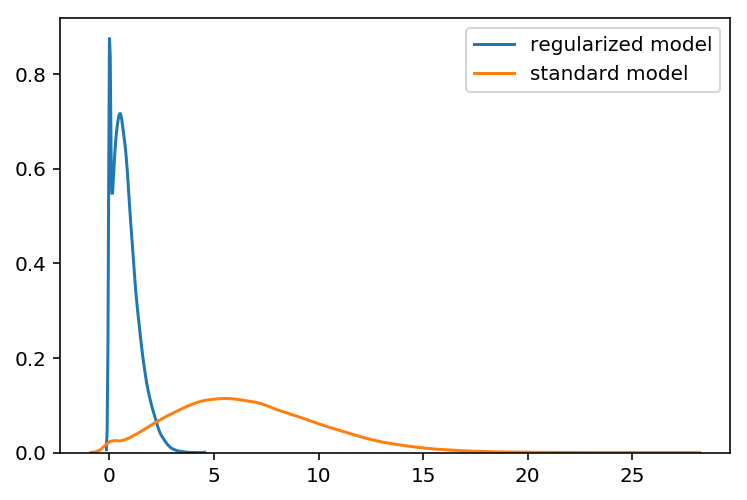

In [26]:
standard_scores = encoded_standard.predict(x_test).ravel()
regularized_scores = encoded_regularized.predict(x_test).ravel()
sns.distplot(regularized_scores, hist=False, label='regularized model')
sns.distplot(standard_scores, hist=False, label='standard model')

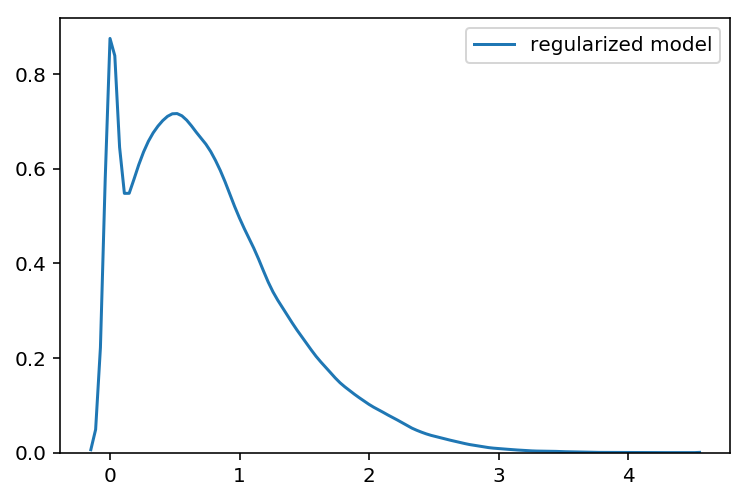

In [27]:
sns.distplot(regularized_scores, hist=False, label='regularized model')